In [1]:
%env CUDA_VISIBLE_DEVICES=3
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
import os
import h5py
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import pandas as pd
from tqdm import tqdm

import random
import torch
import torch.utils.data
import torch.nn.functional as F
import torch_optimizer
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt
from k_space_reconstruction.nets.unet import Unet

torch.manual_seed(228)
random.seed(228)
np.random.seed(228)

env: CUDA_VISIBLE_DEVICES=3


In [2]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(4 * nc, 4), dpi=120, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))


def ce_loss(true, logits, weights, ignore=255):
    torch.nn.CrossEntropyLoss
    ce_loss = torch.nn.functional.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss

def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

def dice_loss(true, logits, eps=1e-7, reduce=True):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps))
    if reduce:
        dice_loss = dice_loss.mean()
    return (1 - dice_loss)

def dice_coeffs(true, logits):
    num_classes = logits.shape[1]
    probas = F.softmax(logits, dim=1)
    probas[probas > 0.5] = 1; probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes):
        pmask[:,0] += i * probas[:,i]
    dice_ls = []
    for i in range(1, num_classes):
        yt = (true==i).float().flatten()
        yp = (pmask==i).float().flatten()
        intersection = torch.sum(yt * yp)
        cardinality = torch.sum(yt + yp)
        dice_ls.append((2. * intersection / (cardinality + 1e-7)).item())
    return dice_ls        

@torch.no_grad()
def test_sampling_pattern(sampling, model, val_generator):
    dice_scores = []
    for data in val_generator:
        simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * sampling).abs()
        pm = model(simg)
        gt = data['mask'].long()
        for i in range(simg.shape[0]):
            dice_scores.append(1 - dice_loss(gt[i][None], pm[i][None]).item())
    return dice_scores

@torch.no_grad()
def test_on_classes_sampling_pattern(sampling, model, val_generator):
    dice_scores = []
    for data in val_generator:
        simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * sampling).abs()
        pm = model(simg)
        gt = data['mask'].long()
        for i in range(simg.shape[0]):
            dice_scores.append(dice_coeffs(gt[i][None], pm[i][None]))
    return dice_scores

class ACDCDataset(torch.utils.data.Dataset):
    CLASSES = {0: 'NOR', 1: 'MINF', 2: 'DCM', 3: 'HCM', 4: 'RV'}

    def __init__(self, hf_path, device):
        super().__init__()
        self.device = device
        self.hf = h5py.File(hf_path)

    def __len__(self) -> int:
        return len(self.hf)

    def __getitem__(self, item: int):
        img = self.hf[str(item)][:1]
        mask = self.hf[str(item)][1:]
        c = self.hf[str(item)].attrs['class']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask)
        mean = img.mean()
        std = img.std()
        img = (img - mean) / (std + 1e-11)
        return dict(
            c=c, 
            mask=mask.to(self.device), 
            img=img.to(self.device), 
            mean=mean[None, None, None].to(self.device), 
            std=std[None, None, None].to(self.device)
        )

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_dataset = ACDCDataset('/dev/shm/train.h5', device)
val_dataset = ACDCDataset('/dev/shm/val.h5', device)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Unet(1, 3+1).to(device).train(False).eval()
for p in model.parameters():
    p.requires_grad = False
model.load_state_dict(torch.load('/home/a_razumov/projects/k-space-mri/notebooks/TMI/acdc/unet-acdc-norot.pt'))

<All keys matched successfully>

In [5]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [16])((256, 256))[0]).cuda().float()
zm = torch.zeros(256).cuda().float()
zm[256//2 - int(16)//2 : 256//2 + int(16)//2] = 1
fm = torch.ones(256).cuda().float()

In [6]:
def norm_alpha(p, alpha):
    pnorm = p.norm(p=1) / p.shape[0]
    m = torch.zeros_like(p)
    m[p >= alpha] = alpha / pnorm * p[p >= alpha]
    m[p < alpha] = 1 - (1 - alpha) / (1 - pnorm) * (1 - p[p < alpha])
    return m

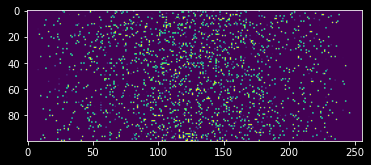

In [7]:
temperature = 0.05
eps = 1e-11
alpha = 1 / 16
thetas = torch.cat([torch.linspace(0.01, 0.9, 128), torch.linspace(0.9, 0.01, 128)])
u = torch.rand(thetas.shape[0], 100).clamp(eps, 1 - eps)
p = norm_alpha(thetas.detach().cpu(), alpha).clamp(eps, 1 - eps)[:, None]
z = ((u.log() - (-u).log1p() + p.log() - (-p).log1p()) / temperature).sigmoid()
plt.imshow(z.T)
plt.show()

In [8]:
from collections import defaultdict

temperature = 0.05
eps = 1e-11
alpha = 1 / 16

thetas = torch.nn.Parameter(
    data=torch.cat([torch.linspace(0.01, 0.9, 128), torch.linspace(0.9, 0.01, 128)]).to(device), 
    requires_grad=True
)

optimizer = torch.optim.Adam([thetas], lr=1e-2, weight_decay=0.)

history = defaultdict(list)

pbar = tqdm(range(100))
for epoch in pbar:
    for data in train_generator:
        u = torch.rand_like(thetas).clamp(eps, 1 - eps)
        p = norm_alpha(thetas, alpha).clamp(eps, 1 - eps)
        z = ((u.log() - (-u).log1p() + p.log() - (-p).log1p()) / temperature).sigmoid()
        simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * z).abs()
        simg = (simg - data['mean']) / (data['std'] + 1e-11)
        simg = simg[:, :, None].view(-1, 1, simg.shape[-2], simg.shape[-1])
        # eval mask
        loss = dice_loss(data['mask'].long(), model(simg))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    for data in val_generator:
        with torch.no_grad():
            u = torch.rand_like(thetas).clamp(eps, 1 - eps)
            p = norm_alpha(thetas, alpha).clamp(eps, 1 - eps)
            pattern = ((u.log() - (-u).log1p() + p.log() - (-p).log1p()) / temperature).sigmoid()
            simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * pattern).abs()
            simg = (simg - data['mean']) / (data['std'] + 1e-11)
            simg = simg[:, :, None].view(-1, 1, simg.shape[-2], simg.shape[-1])
            # eval mask
            loss = dice_loss(data['mask'].long(), model(simg))
            history[epoch].append(loss.item())
    pbar.set_description(f'dice_loss: {np.mean(history[epoch])}')

dice_loss: 0.22371290361180024: 100%|██████████| 100/100 [20:01<00:00, 12.02s/it]


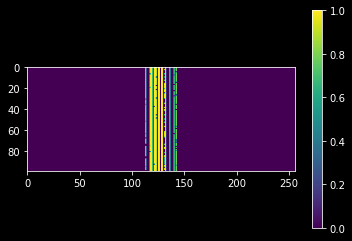

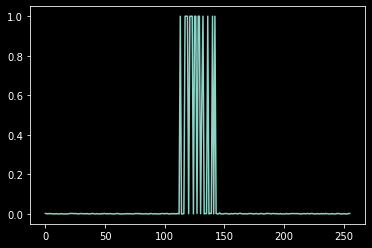

In [9]:
u = torch.rand(thetas.shape[0], 100).clamp(eps, 1 - eps)
p = norm_alpha(thetas.detach().cpu(), alpha).clamp(eps, 1 - eps)[:, None]
b = ((u.log() - (-u).log1p() + p.log() - (-p).log1p()) / temperature).sigmoid()
plt.imshow(b.T)
plt.colorbar()
plt.show()

plt.plot(thetas.detach().cpu().clamp(eps, 1 - eps))
plt.show()

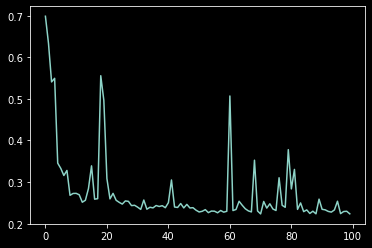

In [10]:
plt.plot([np.mean(history[i]) for i in range(len(history))])
plt.show()

In [11]:
256 * alpha

16.0

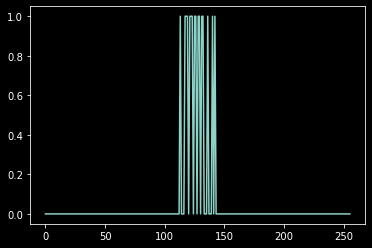

In [12]:
w = torch.zeros_like(pattern)
w[thetas.argsort()[-16:]] = 1
plt.plot(w.cpu())

In [13]:
reparam_w = w.clone()

In [7]:
# torch.save(w, './reparam.pt')
pbopt_w = torch.load('pbopt_16.pt')
reparam_w = torch.load('./reparam.pt').to(device)
loupe_w = torch.load('./loupe.pt').to(device)
igs_w = torch.load('/home/a_razumov/projects/k-space-mri/notebooks/TMI/acdc/sampling_igs_list.pt')[14].to(device)

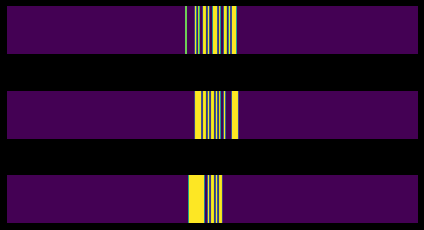

In [8]:
plt.subplot(311)
plt.imshow(reparam_w.repeat(30,1).cpu())
plt.axis('off')
plt.subplot(312)
plt.imshow(loupe_w.repeat(30,1).cpu())
plt.axis('off')
plt.subplot(313)
plt.imshow(pbopt_w.repeat(30,1).cpu())
plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
loupe_w.norm(p=1), reparam_w.norm(p=1), igs_w.norm(p=1), pbopt_w.norm(p=1)

(tensor(16., device='cuda:0'),
 tensor(16., device='cuda:0'),
 tensor(16., device='cuda:0'),
 tensor(16., device='cuda:0'))

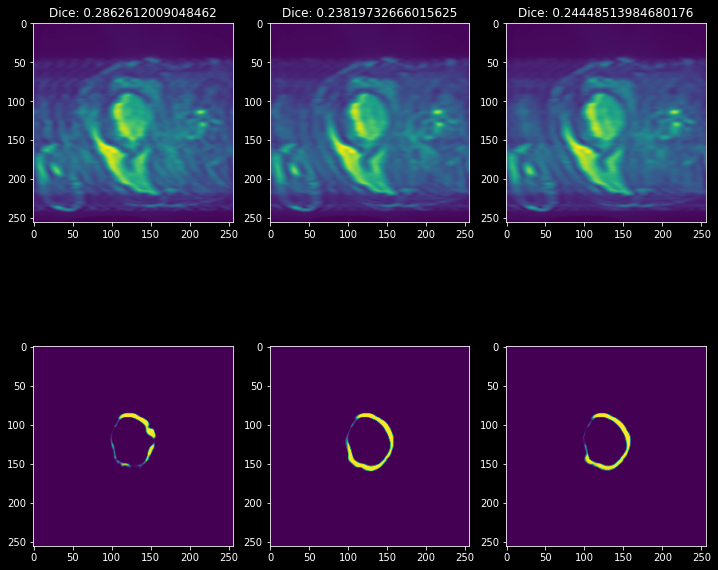

In [10]:
data = val_dataset[20]

plt.figure(figsize=(10,10))

plt.subplot(231)
simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * reparam_w).abs()
plt.imshow(simg[0].cpu())
dv = dice_loss(data['mask'][None].long(), model(simg[None])).item()
plt.title(f'Dice: {dv}')
plt.subplot(234)
plt.imshow(model(simg[None]).softmax(1)[0,2].cpu())

plt.subplot(232)
simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * loupe_w).abs()
plt.imshow(simg[0].cpu())
dv = dice_loss(data['mask'][None].long(), model(simg[None])).item()
plt.title(f'Dice: {dv}')
plt.subplot(235)
plt.imshow(model(simg[None]).softmax(1)[0,2].cpu())

plt.subplot(233)
simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * pbopt_w).abs()
plt.imshow(simg[0].cpu())
dv = dice_loss(data['mask'][None].long(), model(simg[None])).item()
plt.title(f'Dice: {dv}')
plt.subplot(236)
plt.imshow(model(simg[None]).softmax(1)[0,2].cpu())


plt.tight_layout()
plt.show()

In [11]:
dice_scores = dict(
    fastmri=test_sampling_pattern(fastmri_mask_x16, model, val_generator), 
    center=test_sampling_pattern(zm, model, val_generator),
    loupe=test_sampling_pattern(loupe_w, model, val_generator),
    reparam=test_sampling_pattern(reparam_w, model, val_generator),
    igs=test_sampling_pattern(igs_w, model, val_generator),
    pbopt_w=test_sampling_pattern(pbopt_w, model, val_generator),
    full=test_sampling_pattern(fm, model, val_generator),
)

df_dice = pd.DataFrame.from_dict(dice_scores)
df_dice.describe()

,fastmri,center,loupe,reparam,igs,pbopt_w,full
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,0.560492,0.659868,0.704752,0.707400,0.685726,0.707040,0.842170
std,0.200842,0.211512,0.211985,0.208611,0.212825,0.209365,0.177547
min,0.237152,0.245634,0.243402,0.246150,0.246077,0.245440,0.247337
25%,0.389400,0.532080,0.584463,0.579934,0.556879,0.588568,0.837920
50%,0.573000,0.745891,0.800759,0.804697,0.788156,0.796259,0.923483
75%,0.747094,0.835924,0.869219,0.875632,0.854688,0.870857,0.945267
max,0.854637,0.917864,0.937148,0.937753,0.923468,0.936065,0.970603


In [68]:
dice_class_scores = dict(
    fastmri=test_on_classes_sampling_pattern(fastmri_mask_x16, model, train_generator), 
    center=test_on_classes_sampling_pattern(zm, model, train_generator),
    loupe=test_on_classes_sampling_pattern(loupe_w, model, train_generator),
    reparam=test_on_classes_sampling_pattern(reparam_w, model, train_generator),
    full=test_on_classes_sampling_pattern(fm, model, train_generator),
)
class_map = {0: 'RV cavity', 1: 'LV myo', 2: 'LV cavity'}
for name in dice_class_scores.keys():
    arr = np.array(dice_class_scores[name]).T
    print('##############', name, '##############')
    print(pd.DataFrame.from_dict({class_map[i]:arr[i] for i in range(arr.shape[0])}).describe())

############## fastmri ##############
         RV cavity       LV myo    LV cavity
count  1188.000000  1188.000000  1188.000000
mean      0.316251     0.312048     0.514377
std       0.350536     0.223510     0.363810
min       0.000000     0.000000     0.000000
25%       0.000000     0.034440     0.000000
50%       0.082763     0.362950     0.694672
75%       0.693969     0.495118     0.826172
max       0.915982     0.738391     0.952572
############## center ##############
         RV cavity       LV myo    LV cavity
count  1188.000000  1188.000000  1188.000000
mean      0.416105     0.469741     0.662195
std       0.383685     0.262721     0.354500
min       0.000000     0.000000     0.000000
25%       0.000000     0.294607     0.532428
50%       0.465717     0.561120     0.847971
75%       0.819918     0.680559     0.909059
max       0.955144     0.825796     0.965860
############## loupe ##############
         RV cavity       LV myo    LV cavity
count  1188.000000  1188.000000  1